In [ ]:
from src import utils, models
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np
import os 
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# 1. Setup and Data Preparation
- Define dataset paths, frame rate, and neural network configuration. 
- Load pedestrian data for specified situations.

In [7]:
dataset_path = "data/"
situations = ['Bottleneck_Data', 'Corridor_Data']
frame_rate = 1/16

data_loader = utils.data_loader.DataLoader(dataset_path, frame_rate)
data_loader.load_situations(situations)

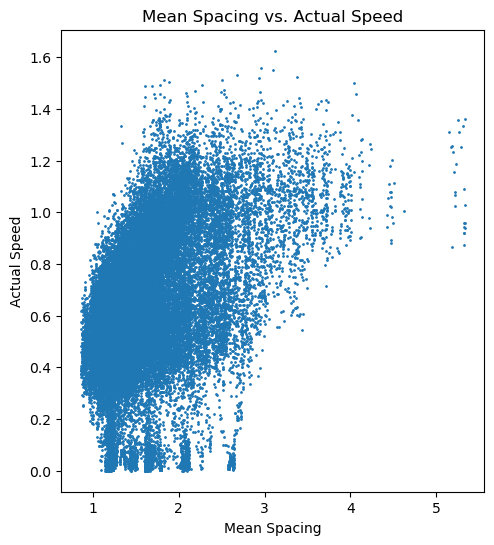

In [8]:
selected_situation = data_loader.get_situation_data('Corridor_Data', 'ug-180-085')

weidmann_model = models.modeling.WeidmannModel()

mean_spacings, updated_data, neighbors = weidmann_model.calculate_mean_spacing(selected_situation, k=10, three_d=False)
agent_speeds = weidmann_model.compute_agent_speeds(updated_data, frame_rate)

utils.visualization.plot_mean_spacing_vs_speed(mean_spacings, agent_speeds)

- Prepare data for neural network training.

In [9]:
neural = models.modeling.NeuralNetworkModel()
input_data, output_data = neural.prepare_training_data(agent_speeds, mean_spacings, neighbors)

- Normalize the data.
- Split the data into training and testing sets.

In [10]:
normalized_input_data = (input_data - np.mean(input_data, axis=0)) / np.std(input_data, axis=0)

X_train, X_test, y_train, y_test = train_test_split(normalized_input_data, output_data, test_size=0.5, random_state=42)

# 3. Neural Network Modeling and Training
- Create and train the neural network model.

In [11]:
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

data = {
    "Corridor_Data": ['ug-180-085', 'ug-180-230', 'ug-180-015'],
    "Bottleneck_Data": ['uo-180-070', 'uo-180-180']
}

for situation_type, scenarios in data.items():
    for scenario in scenarios:
        selected_situation = data_loader.get_situation_data(situation_type, scenario)

        mean_spacings, updated_data, neighbors = weidmann_model.calculate_mean_spacing(selected_situation, k=10, three_d=False)
        agent_speeds = weidmann_model.compute_agent_speeds(updated_data, frame_rate)
        input_data, output_data = neural.prepare_training_data(agent_speeds, mean_spacings, neighbors)

        # Normalize input
        input_data = np.array(input_data, dtype=np.float32)
        output_data = np.array(output_data, dtype=np.float32)
        normalized_input_data = (input_data - np.mean(input_data, axis=0)) / np.std(input_data, axis=0)

        # Train-test split
        X_train, X_test, y_train, y_test = train_test_split(
            normalized_input_data, output_data, test_size=0.5, random_state=42
        )

        input_dim = X_train.shape[1]
        output_dim = 1

        # List of architectures to test
        architectures = [(1,), (2,), (3,), (4, 2), (5, 2), (5, 3), (6, 3), (10, 4), (12, 5)]

        # Storage for losses
        train_losses, test_losses = [], []

        for arch in architectures:
            nn_model = neural.create_nn_model(input_dim, output_dim, arch)  # Keep model on CPU by default

            # Perform bootstrapping (ignore validation loss)
            train_loss, _, test_loss = neural.perform_bootstrapping(
                nn_model, X_train, y_train, X_test, y_test,
                bootstrap_samples=5, bootstrap_size=10, k_folds=5,
                epochs=1, batch_size=32
            )

            train_losses.append(train_loss)
            test_losses.append(test_loss)

        # Convert to NumPy arrays for easier computation
        train_losses = np.array(train_losses)
        test_losses = np.array(test_losses)

        # Extract means and standard deviations for train and test losses
        train_mean, train_std = train_losses[:, 0], train_losses[:, 1]
        test_mean, test_std = test_losses[:, 0], test_losses[:, 1]
        # Plotting
        fig, ax = plt.subplots(figsize=(10, 6))

        x_labels = [str(arch) for arch in architectures]
        x_positions = np.arange(len(architectures))

        # Train Loss with shaded bands
        ax.plot(x_positions, train_mean, label="Train Loss", color="red", marker="o", linewidth=2)
        ax.fill_between(x_positions, train_mean - train_std, train_mean + train_std, color="red", alpha=0.2)

        # Test Loss with shaded bands
        ax.plot(x_positions, test_mean, label="Test Loss", color="gray", marker="^", linewidth=2)
        ax.fill_between(x_positions, test_mean - test_std, test_mean + test_std, color="gray", alpha=0.2)

        # Customizing axes
        ax.set_xticks(x_positions)
        ax.set_xticklabels(x_labels, rotation=45)
        ax.set_xlabel("Architecture", fontsize=12)
        ax.set_ylabel("MSE", fontsize=12)
        ax.legend(fontsize=12)
        ax.grid(True, linestyle="--", alpha=0.6)

        # Title and styling
        plt.title(f"Training and Test Loss - {situation_type} - {scenario}", fontsize=14)
        plt.tight_layout()

        # Ensure directory exists
        os.makedirs("plots", exist_ok=True)

        # Save figure with dynamic filename
        filename = f"plots/{situation_type}_{scenario}_loss.png".replace(" ", "_")
        plt.savefig(filename, dpi=300, bbox_inches="tight")


2025-02-06 18:27:44.187486: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 762ms/step - loss: 2.0851 - val_loss: 1.2695
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 536ms/step - loss: 1.7414 - val_loss: 2.5913
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 463ms/step - loss: 2.2651WARNING:tensorflow:6 out of the last 6 calls to <function TensorFlowTrainer._make_function.<locals>.multi_step_on_iterator at 0x7bd5a8a37d80> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 624ms/step - loss: 2.2651 - val_loss: 0.4691
1/1 ━━━━━━━━━━━━━━━

KeyboardInterrupt: 